In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_datareader
import datetime as dt
import pandas_datareader.data as web
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
from scipy.stats import norm
import statsmodels.api as sm

In [45]:
data = pd.read_csv("NIFTY_50_Data.csv")

In [46]:
data = data[["Date","Close"]]

In [47]:
data = data.rename(columns={'Close':'Data'})

In [48]:
data['Date'] = pd.to_datetime(data.Date)

In [49]:
data.set_index("Date",inplace = True)
data.index = pd.to_datetime(data.index)
data.head()

,Data
Date,
2022-12-30,18105.3
2022-12-29,18191.0
2022-12-28,18122.5
2022-12-27,18132.3
2022-12-26,18014.6


In [50]:
data = data.Data.resample("M").mean()
data = pd.DataFrame(data)
data

,Data
Date,
2010-01-31,5156.205263
2010-02-28,4839.545000
2010-03-31,5178.138095
2010-04-30,5294.730000
2010-05-31,5052.947619
...,...
2022-08-31,17579.065000
2022-09-30,17544.877273
2022-10-31,17406.873684


#### ERROR TREND SEASONALITY(ETS) DECOMPOSITION

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [52]:
result = seasonal_decompose(data['Data'],model = 'additive',period = 12)

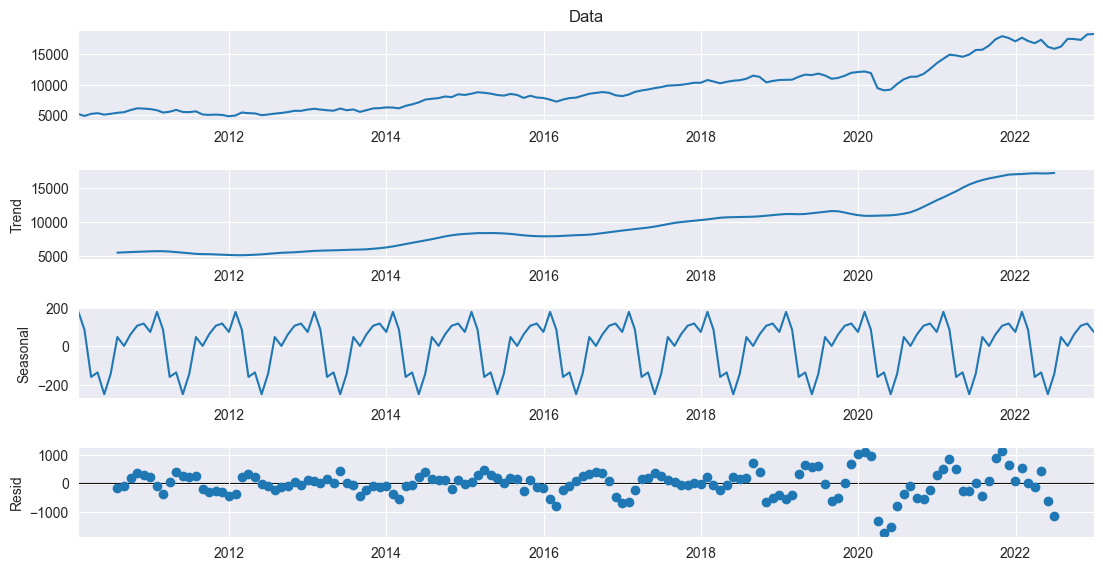

In [53]:
fig = result.plot()
fig.set_size_inches(12,6)

In [54]:
from statsmodels.tsa.stattools import adfuller

In [55]:
ADF = adfuller(data["Data"])

In [56]:
def ADF_CHECK(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ["ADF Test statistic","p-value","# of lags","Num of observations used"]

    for value,label in zip(result,labels):
        print(label + ":" + str(value))
        
    if result[1]<=0.05:
        print("Strong evidence against null hypothesis")
        print("Reject null hypothesis")
        print("Data does not have a unit root and is stationery")
    else:
        print("Weak evidence against null hypothesis")
        print("Fail to reject null hypothesis")
        print("Data has a unit root and it is non-stationery")

In [57]:
ADF_CHECK(data["Data"])

Augmented Dicky-Fuller Test
ADF Test statistic:1.1604129259983287
p-value:0.995700630005306
# of lags:9
Num of observations used:146
Weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root and it is non-stationery


<AxesSubplot: xlabel='Date'>

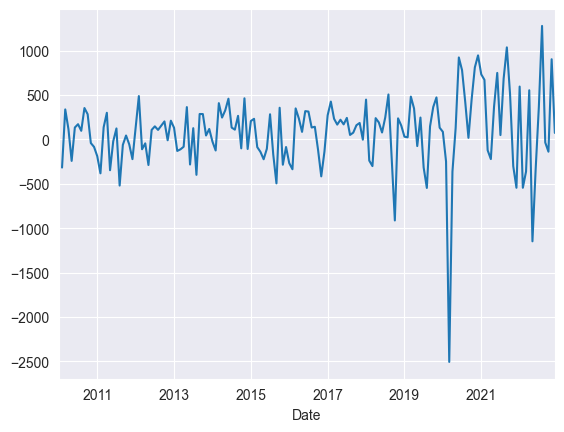

In [58]:
data["First Difference"] = data["Data"]-data["Data"].shift(1)
data["First Difference"].plot()

In [59]:
ADF_CHECK(data["First Difference"].dropna())

Augmented Dicky-Fuller Test
ADF Test statistic:-9.89004605557519
p-value:3.5779615352457975e-17
# of lags:0
Num of observations used:154
Strong evidence against null hypothesis
Reject null hypothesis
Data does not have a unit root and is stationery


<AxesSubplot: xlabel='Date'>

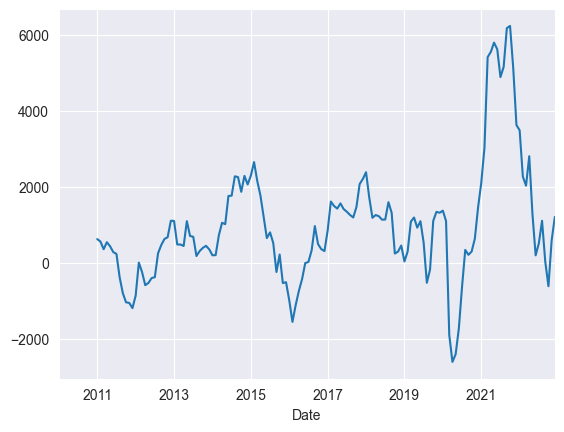

In [60]:
data["Seasonal Difference"] = data["Data"]-data["Data"].shift(12)
data["Seasonal Difference"].plot()

In [61]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

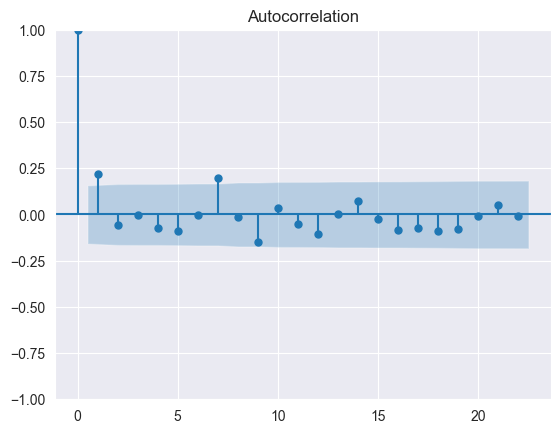

In [62]:
ACF = plot_acf(data["First Difference"].dropna())

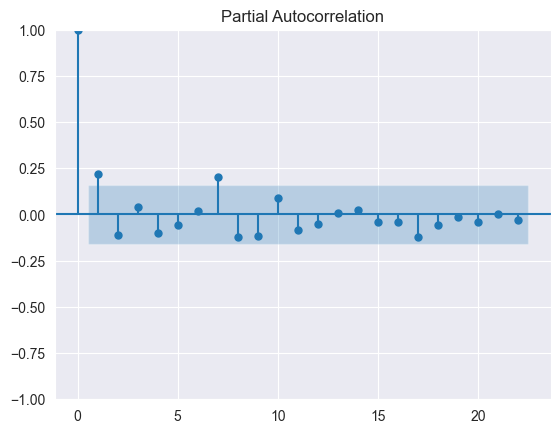

In [63]:
PACF = plot_pacf(data["First Difference"].dropna())

In [64]:
from statsmodels.tsa.arima_model import ARIMA

In [65]:
model = sm.tsa.statespace.SARIMAX(data["Data"],order = (1,1,1),seasonal_order = (1,1,1,12))

######  Order = (P,D,Q) where p is lags in AR, d is differencing and q is lags in MA
###### Seasonal Order = (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)

In [66]:
results = model.fit()

In [67]:
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               Data   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1071.615
Date:                            Fri, 13 Jan 2023   AIC                           2153.230
Time:                                    13:42:05   BIC                           2168.044
Sample:                                01-31-2010   HQIC                          2159.250
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2422      0.256     -0.947      0.344      -0.743       0.259
ma.L1          0.4955      0.235   

<AxesSubplot: xlabel='Date'>

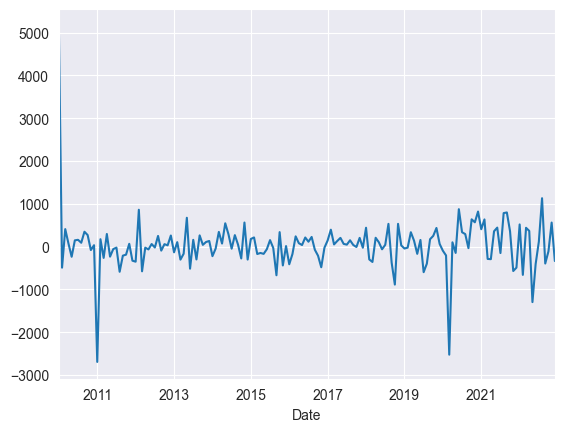

In [68]:
results.resid.plot()

<AxesSubplot: xlabel='Date'>

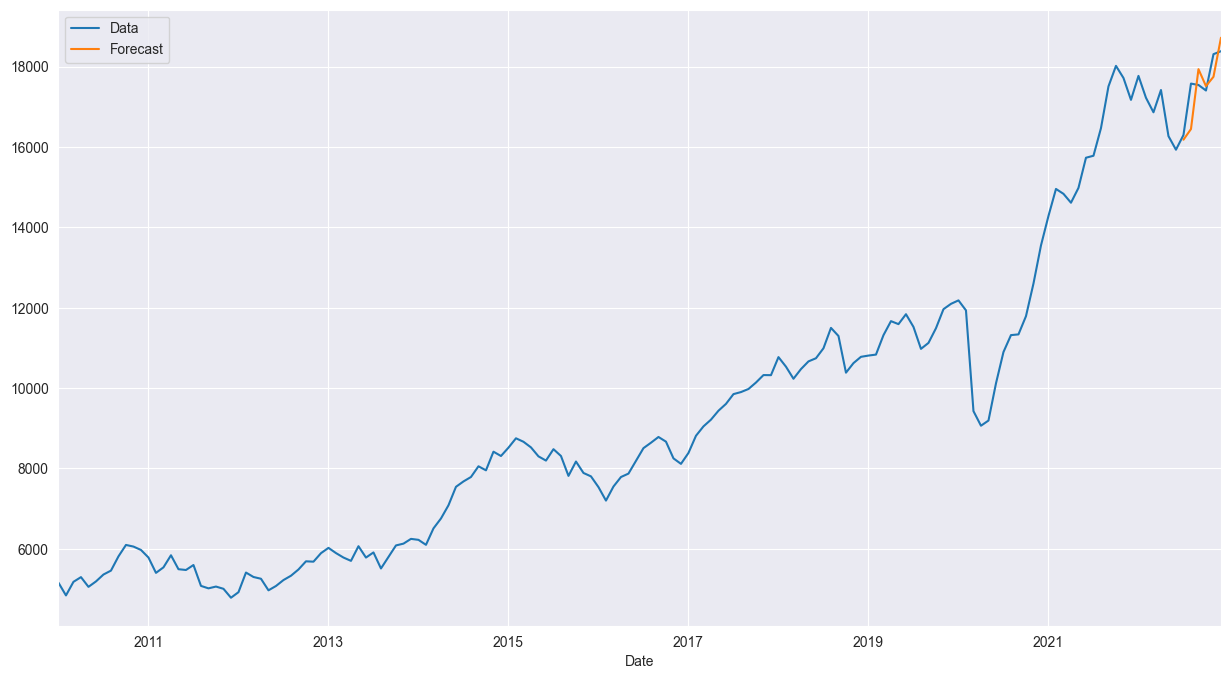

In [69]:
data["Forecast"] = results.predict(start =150, end = 156)
data[["Data","Forecast"]].plot(figsize = (15,8))
#Orange one is the one predicted by the arima model

In [70]:
data.tail()

,Data,First Difference,Seasonal Difference,Forecast
Date,,,,
2022-08-31,17579.065000,1280.043571,1108.605476,16447.215999
2022-09-30,17544.877273,-34.187727,36.262987,17938.386183
2022-10-31,17406.873684,-138.003589,-613.346316,17516.345693
2022-11-30,18311.283333,904.409649,592.390833,17748.184528
2022-12-31,18385.131818,73.848485,1210.862253,18720.771875


In [71]:
from pandas.tseries.offsets import DateOffset

In [72]:
future_dates = [data.index[-1] + DateOffset(months = x) for x in range(1,24)]

In [73]:
future_data = pd.DataFrame(index = future_dates,columns = data.columns)

In [74]:
final_data = pd.concat([data,future_data])
final_data.head()

,Data,First Difference,Seasonal Difference,Forecast
2010-01-31,5156.205263,NaN,NaN,NaN
2010-02-28,4839.545000,-316.660263,NaN,NaN
2010-03-31,5178.138095,338.593095,NaN,NaN
2010-04-30,5294.730000,116.591905,NaN,NaN
2010-05-31,5052.947619,-241.782381,NaN,NaN


In [75]:
final_data["Forecast"] = results.predict(start = 156,end = 180)
final_data["Forecast"][156]

18591.571161463857

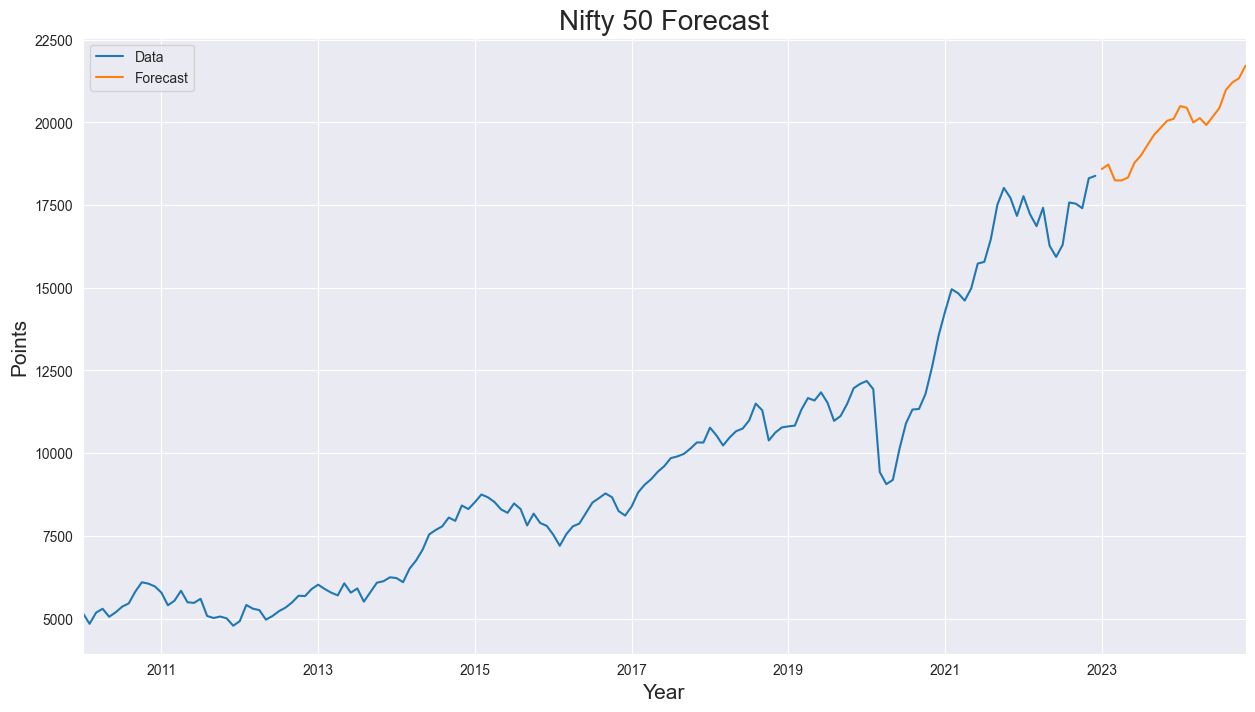

In [76]:
final_data["Data"].plot()
final_data["Forecast"].plot(figsize = (15,8))
plt.title("Nifty 50 Forecast",size = 20)
plt.xlabel("Year",size = 15)
plt.ylabel("Points",size = 15)
plt.legend();